# MNIST Handwritten Digits Classification
*   A comprehensive CNN implementation for digit recognition using PyTorch.
*   Achieves high accuracy through modern deep learning techniques
including data augmentation, batch normalization, dropout regularization, and early stopping



# Data Pre-Processing

## Imports


In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets,transforms
from torch.utils.data.sampler import SubsetRandomSampler

In [11]:
# Set device to GPU if available, otherwise CPU
# This allows for faster training on systems with CUDA-compatible GPUs
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Loading the MNIST Dataset






In [12]:
# Data augmentation for training - improves generalization by creating variations of training data
transform_train = transforms.Compose([
    transforms.RandomRotation(10),  # Rotate images by ±10 degrees to simulate natural handwriting variations
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Translate by ±10% to handle position variations
    transforms.ToTensor(),  # Convert PIL image to tensor and scale pixels from [0,255] to [0,1]
    transforms.Normalize((0.1307,), (0.3081,))  # Standardize using MNIST's mean=0.1307, std=0.3081
])

# Test transformation without augmentation - ensures consistent evaluation conditions
transform_test = transforms.Compose([
    transforms.ToTensor(),  # Convert to tensor and normalize to [0,1] range
    transforms.Normalize((0.1307,), (0.3081,))  # Apply same normalization as training for consistency
])

train_data=datasets.MNIST('./data',train=True,download=True,transform=transform_train)  # Load 60,000 training samples with augmentation
test_data=datasets.MNIST('./data',train=False,download=True,transform=transform_test)  # Load 10,000 test samples without augmentation


## Visualizing the Dataset

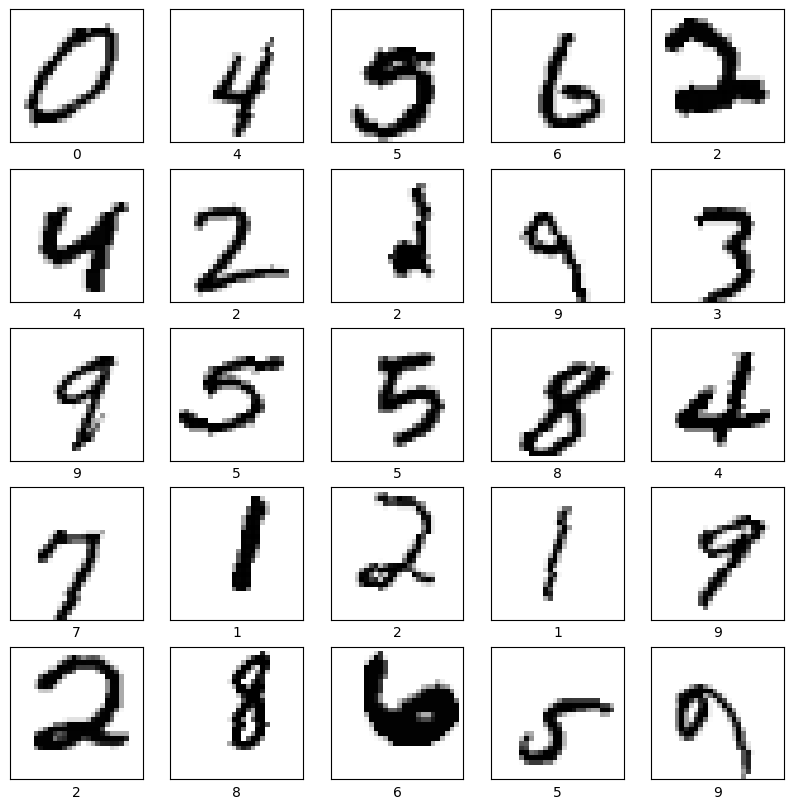

In [13]:
plt.figure(figsize=(10,10))  # Create large figure for clear visualization of 25 samples
train_length = len(train_data)  # Get total number of training samples (60,000)
indices = list(range(train_length))  # Create list of all possible indices
np.random.shuffle(indices)  # Randomize indices to get diverse sample representation

for i in range(25):  # Display 25 random samples in 5x5 grid
    plt.subplot(5, 5, i + 1)  # Create subplot in 5x5 grid layout
    plt.xticks([])  # Remove x-axis ticks for cleaner appearance
    plt.yticks([])  # Remove y-axis ticks for cleaner appearance
    image_index = indices[i]  # Get random image index
    image, label = train_data[image_index]  # Extract image tensor and corresponding label
    plt.imshow(image.squeeze(), cmap=plt.cm.binary)  # Display grayscale image (squeeze removes channel dimension)
    plt.xlabel(label)  # Show true digit label below each image

## DataLoader setup

In [14]:
batch_size = 64  # Process 64 samples per batch - balance between memory usage and gradient stability
valid_size=0.2  # Reserve 20% of training data for validation to monitor overfitting
num_workers=0  # Single-threaded data loading (safer for debugging, can increase for speed)

split = int(np.floor(valid_size * train_length))  # Calculate number of validation samples (12,000)
train_idx, valid_idx = indices[split:], indices[:split]  # Split indices: 48,000 train, 12,000 validation
train_sampler = SubsetRandomSampler(train_idx)  # Random sampler for training subset
valid_sampler = SubsetRandomSampler(valid_idx)  # Random sampler for validation subset

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)  # Training data loader with random sampling
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=valid_sampler, num_workers=num_workers)  # Validation data loader with random sampling
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
    num_workers=num_workers)  # Test data loader (no sampler needed - uses all test data)

In [15]:
len(train_loader),len(valid_loader),len(test_loader)  # Display number of batches in each loader

(750, 188, 157)

# Model Architecture

## Defining the model
Standard formulas used to calculate output shapes: (for convolution & pooling layers)
```
Output = floor((Input + 2×Padding - Kernel) / Stride) + 1

```



In [16]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.features = nn.Sequential(
            # First block - Extract basic features like edges and simple patterns
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  # Input: 1x28x28 → Output: 32x28x28 (32 feature maps)
            nn.BatchNorm2d(32),  # Normalize activations to speed up training and reduce internal covariate shift
            nn.ReLU(inplace=True),  # Non-linear activation function, inplace=True saves memory
            nn.Conv2d(32, 32, kernel_size=3, padding=1),  # Output: 32x28x28 (deeper feature extraction)
            nn.BatchNorm2d(32),  # Batch normalization for stable training
            nn.ReLU(inplace=True),  # ReLU activation for non-linearity
            nn.MaxPool2d(kernel_size=2),  # Output: 32x14x14 (reduce spatial dimensions by half)
            nn.Dropout2d(0.25),  # Randomly zero 25% of feature maps to prevent overfitting

            # Second block - Extract more complex features and patterns
            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # Output: 64x14x14 (increase feature depth)
            nn.BatchNorm2d(64),  # Normalize 64 feature channels
            nn.ReLU(inplace=True),  # Non-linear activation
            nn.Conv2d(64, 64, kernel_size=3, padding=1),  # Output: 64x14x14 (deeper feature learning)
            nn.BatchNorm2d(64),  # Batch normalization for training stability
            nn.ReLU(inplace=True),  # ReLU activation
            nn.MaxPool2d(kernel_size=2),  # Output: 64x7x7 (further spatial reduction)
            nn.Dropout2d(0.25),  # 25% dropout for regularization

            # Third block - Extract high-level abstract features
            nn.Conv2d(64, 128, kernel_size=3, padding=1),  # Output: 128x7x7 (highest feature complexity)
            nn.BatchNorm2d(128),  # Normalize 128 feature channels
            nn.ReLU(inplace=True),  # Non-linear activation
            nn.Dropout2d(0.25)  # Dropout for regularization before classification
        )

        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),  # Global average pooling: 128x7x7 → 128x1x1 (robust to input size)
            nn.Flatten(),  # Convert 2D feature maps to 1D vector: 128x1x1 → 128
            nn.Linear(128, 512),  # Fully connected layer for feature combination and decision making
            nn.BatchNorm1d(512),  # Batch normalization for fully connected layer
            nn.ReLU(inplace=True),  # Non-linear activation
            nn.Dropout(0.5),  # Higher dropout (50%) for fully connected layers to prevent overfitting
            nn.Linear(512, 10)  # Output layer: 512 → 10 classes (digits 0-9)
        )

    def forward(self, x):
        x = self.features(x)  # Pass through convolutional feature extraction layers
        x = self.classifier(x)  # Pass through classification layers
        return x  # Return logits for 10 digit classes

## Training and Validation Phase

In [20]:
def trainCNN(model):
    loss_data={'train':[],'valid':[]}  # Store losses for each epoch to plot training curves
    optimizer = optim.Adam(model.parameters(), lr=1e-3)  # Adam optimizer with 0.001 learning rate (adaptive, works well for most cases)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.5)  # Reduce LR by 50% every 15 epochs for fine-tuning
    epochs = 30  # Maximum number of training epochs
    loss_function = nn.CrossEntropyLoss(label_smoothing=0.1)  # Cross-entropy with label smoothing to prevent overconfident predictions
    patience = 5  # Early stopping: wait 5 epochs without improvement
    patience_counter = 0  # Counter for epochs without validation improvement

    # minimum validation loss ----- set initial minimum to infinity
    valid_loss_min = np.inf  # Track best validation loss for model saving

    for epoch in range(epochs):
        train_loss=0.0  # Accumulate training loss for this epoch
        valid_loss=0.0  # Accumulate validation loss for this epoch
        epoch_start = time.time()  # Record start time for epoch duration calculation

       # TRAINING PHASE
        model.train()  # Set model to training mode (enables dropout and batch norm training)
        for images,labels in train_loader:  # Iterate through training batches
            images, labels = images.to(device), labels.to(device)  # Move data to GPU if available
            optimizer.zero_grad()  # Clear gradients from previous iteration
            output=model(images)  # Forward pass: get model predictions
            loss=loss_function(output,labels)  # Calculate loss between predictions and true labels
            loss.backward()  # Backward pass: compute gradients
            optimizer.step()  # Update model parameters using gradients
            train_loss+=loss.item()  # Accumulate batch loss

       # VALIDATION PHASE
        model.eval()  # Set model to evaluation mode (disables dropout, uses running batch norm stats)
        with torch.no_grad():  # Disable gradient computation for efficiency and memory
            for images,labels in valid_loader:  # Iterate through validation batches
                images, labels = images.to(device), labels.to(device)  # Move data to GPU
                output=model(images)  # Forward pass only (no gradient computation)
                loss=loss_function(output,labels)  # Calculate validation loss
                valid_loss+=loss.item()  # Accumulate validation loss

        train_loss = train_loss/len(train_loader)  # Calculate average training loss per batch
        valid_loss = valid_loss/len(valid_loader)  # Calculate average validation loss per batch
        loss_data['train'].append(train_loss)  # Store training loss for plotting
        loss_data['valid'].append(valid_loss)  # Store validation loss for plotting

        print(f"\nEpoch : {epoch+1}\tTraining Loss : {train_loss}\tValidation Loss : {valid_loss}")
        if valid_loss <= valid_loss_min:  # Check if validation loss improved
            print(f"Validation loss decreased from : {valid_loss_min:.4f} ----> {valid_loss:.4f} ----> Saving Model.......")
            z = type(model).__name__  # Get model class name for file naming
            torch.save(model.state_dict(), z+'_model.pth')  # Save best model weights
            valid_loss_min = valid_loss  # Update best validation loss
            patience_counter = 0  # Reset patience counter
        else:
            patience_counter += 1  # Increment patience counter if no improvement
            if patience_counter >= patience:  # Check if patience exceeded
                print(f"Early stopping triggered after {patience} epochs without improvement")
                break  # Stop training to prevent overfitting
        epoch_time = time.time() - epoch_start  # Calculate epoch duration
        print(f"Epoch completed in {epoch_time:.2f} seconds")

        scheduler.step()  # Update learning rate according to schedule

    return(loss_data)  # Return loss history for plotting

In [21]:
cnn_model=CNN()  # Initialize CNN model instance
cnn_model.to(device)  # Move model to GPU if available
cnn_loss=trainCNN(cnn_model)  # Train the model and get loss history


Epoch : 1	Training Loss : 1.0388570999304454	Validation Loss : 0.6149276900798717
Validation loss decreased from : inf ----> 0.6149 ----> Saving Model.......
Epoch completed in 29.44 seconds

Epoch : 2	Training Loss : 0.6710462566216787	Validation Loss : 0.5779898797578
Validation loss decreased from : 0.6149 ----> 0.5780 ----> Saving Model.......
Epoch completed in 28.39 seconds

Epoch : 3	Training Loss : 0.625413906176885	Validation Loss : 0.5653317291685875
Validation loss decreased from : 0.5780 ----> 0.5653 ----> Saving Model.......
Epoch completed in 28.47 seconds

Epoch : 4	Training Loss : 0.6037859665552775	Validation Loss : 0.5517362838095807
Validation loss decreased from : 0.5653 ----> 0.5517 ----> Saving Model.......
Epoch completed in 29.92 seconds

Epoch : 5	Training Loss : 0.5886094521681468	Validation Loss : 0.5528803372636755
Epoch completed in 29.00 seconds

Epoch : 6	Training Loss : 0.5811287019252777	Validation Loss : 0.5441988823895759
Validation loss decreased fr

### Loading model from Lowest Validation Loss

In [22]:
cnn_model.load_state_dict(torch.load('CNN_model.pth', map_location=device))  # Load best model weights, map_location ensures device compatibility
print(cnn_model.state_dict)  # Print confirmation of loaded model parameters

<bound method Module.state_dict of CNN(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout2d(p=0.25, inplace=False)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(kernel_size=2, st


### Plotting Training and Validation Losses

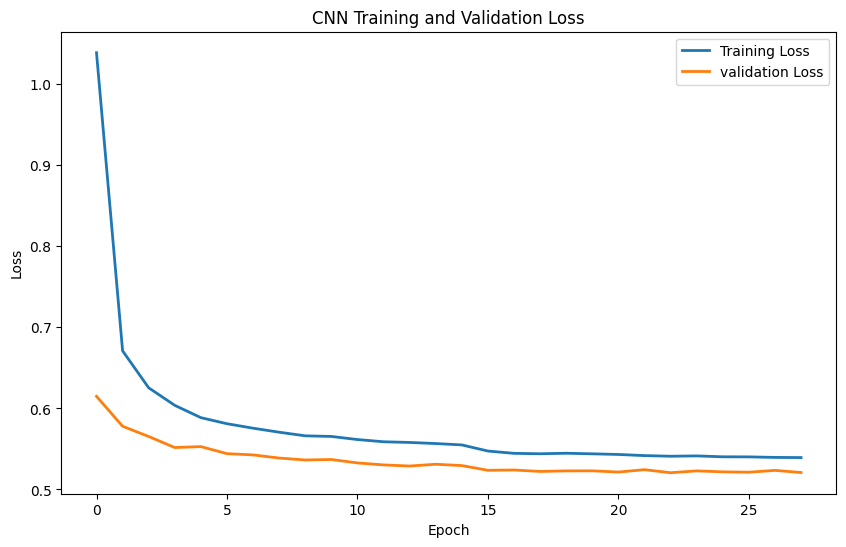

In [23]:
plt.figure(figsize=(10, 6))  # Create figure for loss visualization
plt.plot(cnn_loss['train'], label='Training Loss',linewidth=2)  # Plot training loss curve
plt.plot(cnn_loss['valid'], label='validation Loss', linewidth=2)  # Plot validation loss curve
plt.title('CNN Training and Validation Loss')  # Add descriptive title
plt.xlabel('Epoch')  # Label x-axis
plt.ylabel('Loss')  # Label y-axis
plt.legend()  # Show legend to distinguish curves
plt.show()  # Display the plot

## Testing Phase

In [32]:
def testCNN(model):
    correct=0  # Counter for total correct predictions (unused in current implementation)
    test_loss=0  # Accumulate test loss across all batches
    class_correct = list(0. for i in range(10))  # Track correct predictions for each digit class (0-9)
    class_total = list(0. for i in range(10))  # Track total predictions for each digit class
    loss_function = nn.CrossEntropyLoss()  # Standard cross-entropy loss for testing (no label smoothing)

    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # Disable gradient computation for efficiency
        for images,labels in test_loader:  # Iterate through test batches
            images, labels = images.to(device), labels.to(device)  # Move data to GPU
            output=model(images)  # Get model predictions
            loss=loss_function(output,labels)  # Calculate loss for this batch
            test_loss+=loss.item()  # Accumulate test loss
            _,pred=torch.max(output,1)  # Get predicted class (highest probability)
            correct = np.squeeze(pred.eq(labels.data.view_as(pred)))  # Compare predictions with true labels

            current_batch_size = labels.size(0)  # Get actual batch size (may be smaller for last batch)
            for i in range(current_batch_size):  # Iterate through samples in batch
                label = labels.data[i]  # Get true label for sample i
                class_correct[label] += correct[i].item()  # Increment correct count for this class
                class_total[label] += 1  # Increment total count for this class

    test_loss=test_loss/len(test_loader)  # Calculate average test loss

    print(f'For {type(model).__name__} :')  # Print model name
    print(f"Test Loss: {test_loss:.4f}")  # Display average test loss
    print(f"Correctly predicted per class : {class_correct}")  # Show correct predictions per digit
    print(f"Total correctly predicted : {sum(class_correct)}")  # Show total correct predictions
    print(f"Total Predictions per class : {class_total}")  # Show total predictions per digit
    print(f"Total predictions to be made : {sum(class_total)}\n")  # Show total test samples

    for i in range(10):  # Calculate and display per-class accuracy
        if class_total[i] > 0:  # Check if class has test samples
            accuracy = 100 * class_correct[i] / class_total[i]  # Calculate accuracy percentage
            print(f"Test Accuracy of class {i} : {accuracy:.2f}% where {int(class_correct[i])} of {int(class_total[i])} were predicted correctly")
        else:
            print(f'Test Accuracy of class {i}: N/A (no test examples)')  # Handle case with no samples

    overall_accuracy = 100. * sum(class_correct) / sum(class_total)  # Calculate overall accuracy
    print(f"\nOverall Test Accuracy : {overall_accuracy:.2f}% where {int(sum(class_correct))} of {int(sum(class_total))} were predicted correctly")

    # obtain one batch of test images
    dataiter = iter(test_loader)  # Create iterator for test data
    images, labels = next(dataiter)  # Get first batch of test images
    images, labels = images.to(device), labels.to(device)  # Move to GPU
    output = model(images)  # Get model predictions for visualization

    # convert output probabilities to predicted class
    _, preds = torch.max(output, 1)  # Get predicted classes (highest probability)

    # prep images for display
    images = images.cpu()  # Move images back to CPU for matplotlib
    preds = preds.cpu()  # Move predictions to CPU
    labels = labels.cpu()  # Move true labels to CPU

    indices = np.random.choice(len(images), size=16, replace=False)  # Select 16 random images from batch
    plt.figure(figsize=(10, 10))  # Create large figure for visualization
    for i, idx in enumerate(indices):  # Iterate through selected images
        ax = plt.subplot(4, 4, i + 1)  # Create 4x4 subplot grid

        # Remove ticks
        ax.set_xticks([])  # Remove x-axis ticks for cleaner look
        ax.set_yticks([])  # Remove y-axis ticks for cleaner look

        # Display image
        ax.imshow(images[idx].squeeze(), cmap='binary')  # Show grayscale image

        # Get labels
        pred_label = preds[idx].item()  # Get predicted digit
        true_label = labels[idx].item()  # Get true digit

        # Color code: green for correct, red for incorrect
        color = 'green' if pred_label == true_label else 'red'  # Green for correct, red for wrong predictions

        # Set title with full predicted and true labels
        ax.set_title(f"Predicted: {pred_label}\nTrue: {true_label}",
                    color=color, fontsize=12, pad=10)  # Display prediction vs truth with color coding

    plt.suptitle("CNN Predictions on Random Test Images", fontsize=20, y=0.98)  # Main title for the visualization
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to prevent overlap
    plt.subplots_adjust(hspace=0.5, wspace=0.3)  # Add space between subplots for better readability
    plt.show()  # Display the visualization

For CNN :
Test Loss: 0.0865
Correctly predicted per class : [979.0, 1131.0, 1029.0, 1009.0, 979.0, 885.0, 952.0, 1023.0, 971.0, 1002.0]
Total correctly predicted : 9960.0
Total Predictions per class : [980.0, 1135.0, 1032.0, 1010.0, 982.0, 892.0, 958.0, 1028.0, 974.0, 1009.0]
Total predictions to be made : 10000.0

Test Accuracy of class 0 : 99.90% where 979 of 980 were predicted correctly
Test Accuracy of class 1 : 99.65% where 1131 of 1135 were predicted correctly
Test Accuracy of class 2 : 99.71% where 1029 of 1032 were predicted correctly
Test Accuracy of class 3 : 99.90% where 1009 of 1010 were predicted correctly
Test Accuracy of class 4 : 99.69% where 979 of 982 were predicted correctly
Test Accuracy of class 5 : 99.22% where 885 of 892 were predicted correctly
Test Accuracy of class 6 : 99.37% where 952 of 958 were predicted correctly
Test Accuracy of class 7 : 99.51% where 1023 of 1028 were predicted correctly
Test Accuracy of class 8 : 99.69% where 971 of 974 were predicted c

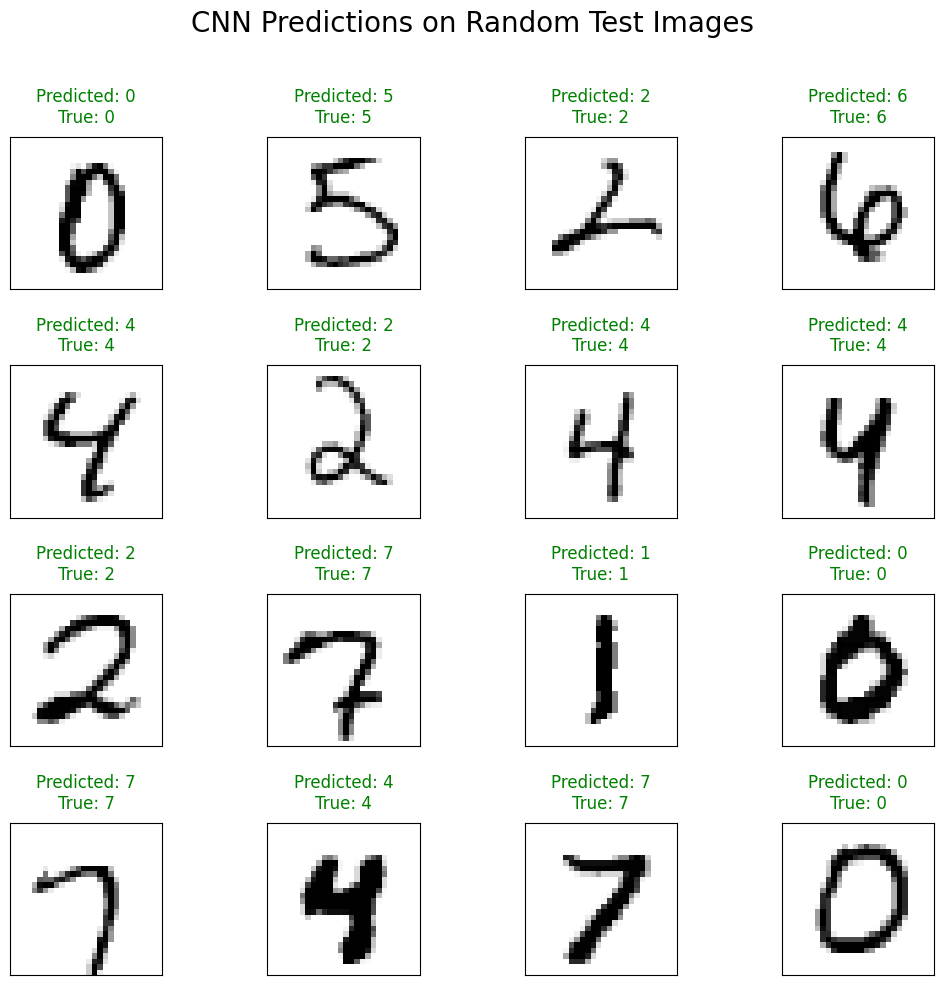

In [33]:
testCNN(cnn_model)  # Run comprehensive testing and visualization